# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [61]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:
>**PCA**  
tries to find correlations by looking for the maximum variance. So the first dimensions for the PCs are, what has the largest range of values in the data set.  
Possible first dimensions:
- the amount in which a certain category is replenished
- the size of the customers business

>**ICA**  
tries to transform the feature space towards maximal independence. So the first dimension will contain the most common information in the data set. And the following dimensions will consist of the least common information. 
Possible type of vectors dimensions: 
- the average replenishment profile of a category
- different replenishment profiles

source: https://www.udacity.com/course/viewer#!/c-ud727-nd/l-5453051650/m-661438547

### PCA

In [62]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA

pca = PCA(n_components = data.shape[1])
pca.fit(data)
#http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

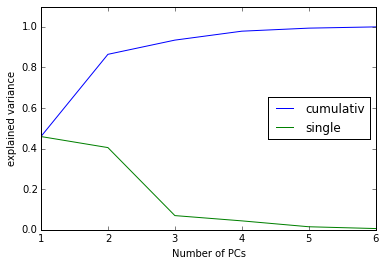

In [63]:
# PCs variance plot

cs = np.cumsum(pca.explained_variance_ratio_)
#https://github.com/numpy/numpy/blob/v1.10.0/numpy/core/fromnumeric.py#L2038-L2106
#http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.cumsum.html

# Number array for PCs
num_PCs = np.arange(data.shape[1])+1
#http://docs.scipy.org/doc/numpy-1.10.1/user/basics.creation.html

plt.plot(num_PCs, cs)
plt.plot(num_PCs, pca.explained_variance_ratio_)
#http://matplotlib.org/users/pyplot_tutorial.html

plt.axis([1, data.shape[1], 0, 1.1])
plt.xlabel('Number of PCs')
plt.ylabel('explained variance')
plt.legend(['cumulativ', 'single'], loc='center right')
plt.show()

Answer: 
>The first two PCs make for more than 80% of explained variance. The third PC adds 7% to explained variance. All additional PCs add less than 5% to explained variance. 
Depending on how much I want/need to reduce my data set, I would pick the first 2 to 3 PCs. In this case, with a relatively small dataset, it is reasonable to use 3 PCs. To retain as much information as possible. With larger datasets, I probably go for only 2 PCs, because it is computational cheaper/faster.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 
> These dimensions represent the directions in R<sup>6</sup> that show the most variance i.e. the largest range of values.   
Probably the **first dimension** is the **amount of money** that is spent on a single category by a single customer. The **second dimension** is most likely the **size of the customer** companies.

### ICA

In [64]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn import preprocessing

# feature centering
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=False).fit(data.astype(float))
data_centered = scaler.transform(data)
# http://scikit-learn.org/stable/modules/preprocessing.htmltable/auto_examples/decomposition/plot_faces_decomposition.html#example-decomposition-plot-faces-decomposition-py

ica = FastICA()
ica.fit(data_centered).transform(data_centered)
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA

# Print the independent components
print ica.components_

[[  3.97577529e-06  -8.57722898e-07  -6.17592362e-07  -6.78033019e-07
    2.04656928e-06  -1.04710812e-06]
 [ -3.01075164e-07   2.29286891e-06   1.20935760e-05  -1.46078737e-06
   -2.82131466e-05  -5.73352593e-06]
 [  8.65272257e-07   1.40202318e-07  -7.74300983e-07  -1.11460814e-05
    5.56348840e-07   5.95245547e-06]
 [ -1.53254793e-07  -9.84727795e-06   5.80462086e-06   3.64854659e-07
   -3.29897145e-06   6.06014274e-06]
 [ -3.86380883e-07  -2.19533634e-07  -6.01497570e-07  -5.22101905e-07
    5.10657739e-07   1.80928495e-05]
 [  2.11395954e-07  -1.89376663e-06   6.36725036e-06   4.18725764e-07
   -6.72117798e-07  -1.42692381e-06]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 
> The first vector is the average (standardized) replenishment profile over all categories. The second to sixth vector are (standardized) building blocks that can be linearly combined with the first vector to creat replenishment profiles for each of the six categories.


## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 
> #### K-Means advantages  
> - "scales well to [a] large number of samples."
> - "General-purpose" clustering algorithm
> - "has been used (successfully) across a large range of application areas."
> - "K-Means can be seen as a special case of Gaussian mixture model with equal covariance per component."

> #### Gaussian Mixture Models advantages  
> - "incorporate information about the covariance structure of the data."
> - "can also draw confidence ellipsoids for multivariate models."
> - "compute the Bayesian Information Criterion to assess the number of clusters in the data."
> - "it is the fastest algorithm for learning mixture models."
> - "as this algorithm maximizes only the likelihood, it will not be bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply."

source: http://scikit-learn.org/stable/modules/mixture.html#mixture, http://scikit-learn.org/stable/modules/clustering.html#k-means, https://www.udacity.com/course/viewer#!/c-ud727-nd/l-5455061279/m-638188663

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [65]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [66]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation

pca2 = PCA(n_components = 2)
reduced_data = pca2.fit(data).transform(data)
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#example-decomposition-plot-pca-vs-lda-py

print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [67]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#clf = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10) #{'k-means++', 'random' or an ndarray}
clf = GMM(n_components = 5, n_init = 10)

# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM

clusters = clf.fit(reduced_data)

#for KMeans
#print clf.inertia_

#for GMM
#print clf.converged_

print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=5, n_init=10, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)


In [68]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [69]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

# for KMeans
#centroids = clf.cluster_centers_

# for GMM
centroids = clf.means_

print centroids

[[  7189.91286381   6031.87459686]
 [ -4647.84385127  -5938.71387776]
 [-21594.97891001  -3437.82018436]
 [ -9453.97791748  32203.92662496]
 [  6696.36676866  -6467.64552512]]


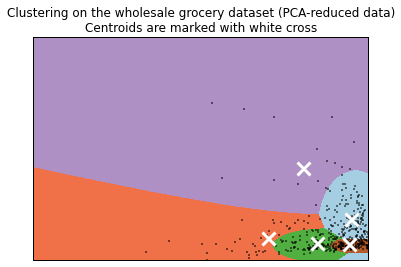

In [70]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
> **lower-left cluster**: bigger and medium sized customers how are ordering small quantities  
> **low-middle cluster**: medium sized companies with a limited turnover  
> **lower-right**: a huge number of small customers how are ordering small quantities  
> **middle-right cluster**: smaller and medium sized customers how order quite heavily  
> **top cluster**: companies of all size ordering huge quantities

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 
> On a very basic level, the 2D plotting of the PCA reduced samples gave me the most inside overall.   
Beyond that, it seems that GMM fits the data better with its ellipsoid cluster borders. But KMeans is doing a decent job as well. I gained further inside by varying the number of centroids/clusters regardless of the algorithm.  

> As I mentioned above, I think it would make sense to use the third PC as well. To see if any cluster "splits" in the third dimension:

In [1]:
pca3 = PCA(n_components = 3)
reduced_data_2 = pca3.fit(data).transform(data)
reduced_data_2 = reduced_data_2[:,1:3]

NameError: name 'PCA' is not defined

In [97]:
# The visualizer below assumes your clustering object is named 'clusters'

clf = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10) #{'k-means++', 'random' or an ndarray}
#clf = GMM(n_components = 5, n_init = 10)

# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM

clusters_2 = clf.fit(reduced_data_2)

#for KMeans
print clf.inertia_

#for GMM
#print clf.converged_

print clusters_2

13468228268.3
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [98]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min_2, x_max_2 = reduced_data_2[:, 0].min() - 1, reduced_data_2[:, 0].max() + 1
y_min_2, y_max_2 = reduced_data_2[:, 1].min() - 1, reduced_data_2[:, 1].max() + 1
hx_2 = (x_max_2-x_min_2)/1000.
hy_2 = (y_max_2-y_min_2)/1000.
xx_2, yy_2 = np.meshgrid(np.arange(x_min_2, x_max_2, hx_2), np.arange(y_min_2, y_max_2, hy_2))

# Obtain labels for each point in mesh. Use last trained model.
Z_2 = clusters_2.predict(np.c_[xx_2.ravel(), yy_2.ravel()])

In [99]:
# for KMeans
centroids_2 = clf.cluster_centers_

# for GMM
#centroids_2 = clf.means_

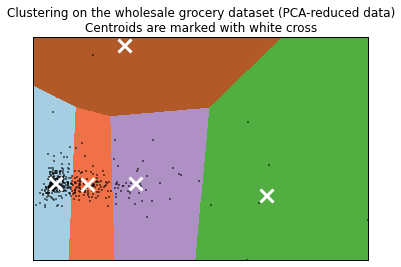

In [100]:
# Put the result into a color plot
Z_2 = Z_2.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_2, interpolation='nearest',
           extent=(xx_2.min(), xx_2.max(), yy_2.min(), yy_2.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data_2[:, 0], reduced_data_2[:, 1], 'k.', markersize=2)
plt.scatter(centroids_2[:, 0], centroids_2[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min_2, x_max_2)
plt.ylim(y_min_2, y_max_2)
plt.xticks(())
plt.yticks(())
plt.show()

> The third PC plot looks very symmetric (except for some outliers). 
> It does not add much information concerning the clustering.
> It is the same clusters dragged out into another dimension. No interesting splits to see. All centroids almost on one line.
> Besides, it is hard to find a description for the third dimension. It is not clear which information is contained in there.

**9)** How would you use that technique to help the company design new experiments?

Answer:  
> In the first step, this new clustering information should be connected to other customer data for new insides. Geolocation could be interesting, or when the actual orders are placed.  
Another interesting experiment would be to track the developments over time. For single customers and the whole set. Maybe there is a customer-life-cycle, where they move through different clusters over time. It might be possible to make and algorithm that could learn this pattern and make predictions, how a new customer might evolve.

**10)** How would you use that data to help you predict future customer needs?

Answer:  
> You can make better predictions if you put a new customer into the designated cluster first and make your predictions from there. Instead of predicting from the whole set of customers i.e. the average customer.  
> This information can be used for cross- and upselling offers as well as bulk discounts, depending on the cluster.
Sells people can use this data to see if a certain customer has weak sells in a certain category, compared with the other "reference customers" in the cluster. They might be able to identify opportunities for new offers to these customers.